(sec-ray-tune)=
# Ray Tune

Ray Tune is mainly targeting hyperparameter tuning scenarios, combining model training, hyperparameter selection and parallel computing. It is based on Ray's Actor, Task and Ray Train. It launches multiple machine learning training tasks in parallel and selecting the best hyperparameters. Ray Tune is compatible with common machine learning training frameworks such as PyTorch, Keras, and XGBoost, and provides common hyperparameter tuning algorithms (such as random search, Bayesian optimization, etc.) and tools ([Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://github.com/optuna/optuna)). Users can perform batched hyperparameter tuning on Ray clusters based on Ray Tune. Readers can read {numref}`sec-hyperparameter-optimization` to review the background knowledge of hyperparameter tuning.


## Key components

Ray Tune mainly includes the following components:
* Abstract the original training process into a trainable function (Trainable)
* Define the hyperparameter search space to be searched
* Use search algorithms and schedulers for parallel training and scheduling.

{numref}`fig-ray-tune-key-parts` shows the key parts of Ray Tune. The user creates a [`Tuner`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.Tuner.html), which contains the Trainable function to be trained, the hyperparameter search space, and the user-choosen search algorithm or a scheduler. Different hyperparameter combinations form different experiments, and Ray Tune trains in parallel based on the resources requested by the user and the existing resources of the cluster. The user can analyze the results of multiple experiments.


```{figure} ../img/ch-ray-ml/ray-tune-key-parts.svg
---
width: 600px
name: fig-ray-tune-key-parts
---
Ray Tune Key parts
```

## Trainable

Like other hyperparameter optimization libraries, Ray Tune requires an optimization objective, which is the direction that Ray Tune tries to optimize, generally some machine learning training indicators, such as the accuracy of model predictions. Ray Tune users need to encapsulate the optimization objective in a trainable function, which can be modified on the original single-node machine learning training code. The Trainable function receives a dictionary-style configuration, and the keys in the dictionary are the hyperparameters to be searched. In the Trainable function, the optimization objective is stored in the form of `ray.train.report(...)`, or returned directly as the return value of the Trainable function. For example, if the user wants to tune the hyperparameter `lr` and the optimization objective is `score`, in addition to the necessary training code, the Trainable function is as follows:

```python
def trainable(config):
    lr = config["lr"]
    
    # Training code ...

    # Return optimization target using ray.train.report
    ray.train.report({"score": ...})
    # Or use return or yield to return directly
    return {"score": ...}
```

### Example: Image classification

Based on the image classification example and search for the two hyperparameters `lr` and `momentum`. The Trainable function is `train_mnist()` in the code:

In [2]:
import os
import tempfile

import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.models import resnet18

from ray import tune
from ray.tune.schedulers import ASHAScheduler

import ray
import ray.train.torch
from ray.train import Checkpoint

In [3]:
data_dir = os.path.join(os.getcwd(), "../data")

def train_func(model, optimizer, criterion, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

def train_mnist(config):
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), 
         torchvision.transforms.Normalize((0.5,), (0.5,))]
    )

    train_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform),
        batch_size=128,
        shuffle=True)
    test_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform),
        batch_size=128,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    # train for 10 epoch
    for epoch in range(10):
        train_func(model, optimizer, criterion, train_loader)
        acc = test_func(model, test_loader)

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (epoch + 1) % 5 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            ray.train.report({"mean_accuracy": acc}, checkpoint=checkpoint)

Ray Tune supports both function and class methods to define Trainable. In this example, the function method is used. The difference between the function method and the class method is shown in {numref}`tab-function-class-trainable`.

```{table} Differences between defining Trainable in function and class
:name: tab-function-class-trainable
|      Content       |                Function API                 |                 Class API                  |
| :----------------: | :----------------------------------------: | :----------------------------------------: |
| One training iteration | Each time `train.report` is called, the number of iterations increases by one | Each time `Trainable.step()` is called, the number of iterations increases by one |
| Report back | Call `train.report(metrics)`                     | Returned by `Trainable.step()`        |
| Write Checkpoint | Call `train.report(..., checkpoint=checkpoint)`  | Implement `Trainable.save_checkpoint()`                |
| Read Checkpoint| Call `train.get_checkpoint()`                   | Implement `Trainable.load_checkpoint()`                |
| Read different hyperparameter combinations | `config` in `def train_func(config):` | `config` passed in `Trainable.setup(self, config)` |
```

## Search Space

The search space is the possible values ​​of the hyperparameters. Ray Tune provides some methods to define the search space. For example, [`ray.tune.choice()`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.sample_from.html) selects possible values ​​from a range, and [`ray.tune.uniform()`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.uniform.html) selects possible values ​​from a uniform distribution. Now set the search space for the two hyperparameters `lr` and `momentum`:

In [4]:
search_space = {
    "lr": tune.choice([0.001, 0.002, 0.005, 0.01, 0.02, 0.05]),
    "momentum": tune.uniform(0.1, 0.9),
}

## Search algorithm and scheduler

In Ray Tune's hyperparameter search, the core concepts are search algorithm and scheduler. The search algorithm is responsible for selecting hyperparameter combinations from the search space for experimentation; the scheduler terminates poorly performing experiments to save computing resources. The search algorithm is required, but the scheduler is not. For example, you can combine random search with the ASHA scheduler to let the scheduler terminate some poorly performing experiments.

In addition, some hyperparameter optimization libraries such as [Hyperopt](https://github.com/hyperopt/hyperopt) and [Optuna](https://github.com/optuna/optuna) usually provide encapsulated search algorithms, and some libraries also provide schedulers. These libraries have their own specific usage methods. Ray Tune encapsulates these libraries to unify the usage experience of different libraries.

The following is an example of using random search:

In [5]:
trainable_with_gpu = tune.with_resources(train_mnist, {"gpu": 1})

tuner = tune.Tuner(
    trainable_with_gpu,
    param_space=search_space,
)
results = tuner.fit()

(train_mnist pid=41485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-20-25/train_mnist_421ef_00000_0_lr=0.0020,momentum=0.2905_2024-04-11_21-20-26/checkpoint_000000)
(train_mnist pid=41485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-20-25/train_mnist_421ef_00000_0_lr=0.0020,momentum=0.2905_2024-04-11_21-20-26/checkpoint_000001)
2024-04-11 21:24:22,692	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHE

The scheduler analyzes the performance of each trial and uses an early stopping strategy to terminate poorly performing trials early to save computing resources and allocate resources to the most promising trials. The following example uses the [ASHA algorithm](https://openreview.net/forum?id=S1Y7OOlRZ) {cite}`li2018Massively` for scheduling.

In the previous example, no [`ray.tune.TuneConfig`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.TuneConfig.html) is set, and only one trial is performed by default. Next, we set the `num_samples` parameter in `ray.tune.TuneConfig`, which defines the number of trials to run. At the same time, use [ray.tune.schedulers.ASHAScheduler](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.ASHAScheduler.html) to terminate poorly performing experiments and leave resources for more promising experiments. The parameters `metric` and `mode` of `ASHAScheduler` define the metric and direction of optimization. In this case, the goal is to maximize "mean_accuracy".

In [6]:
tuner = tune.Tuner(
    trainable_with_gpu,
    tune_config=tune.TuneConfig(
        num_samples=16,
        scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    ),
    param_space=search_space,
)
results = tuner.fit()

(train_mnist pid=41806) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00002_2_lr=0.0020,momentum=0.4789_2024-04-11_21-24-22/checkpoint_000000)
(train_mnist pid=42212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00005_5_lr=0.0050,momentum=0.8187_2024-04-11_21-24-22/checkpoint_000000) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_mnist pid=41806) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22/train_mnist_cf61b_00002_2_lr=0.0020,momentum=0.4789_2024-04-11_21-24-22/checkpoint_000001)
(train_mnist pid=41809) Checkpoint succes

2024-04-11 21:34:30,051	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-11 21:34:30,067	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/train_mnist_2024-04-11_21-24-22' in 0.0224s.
2024-04-11 21:34:30,083	INFO tune.py:1048 -- Total run time: 607.32 seconds (607.25 seconds for the tuning loop).


During the training process, the selected hyperparameter values ​​and targets for each trial are printed on the screen. For trials with poor performance, early stopping is adopted after a few iterations. We visualize the results of these trials:

Text(0, 0.5, 'Mean Accuracy')

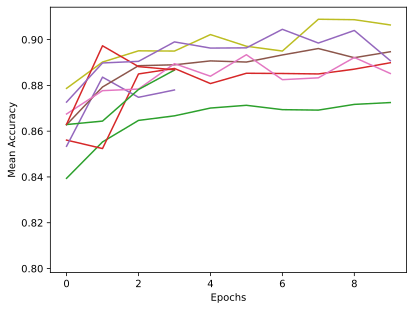

In [7]:
%config InlineBackend.figure_format = 'svg'

dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Accuracy")

The above is a complete example of Ray Tune. Next, we will show several examples using different search algorithms and schedulers.

## Example: Airplane Delay Prediction

This example uses XGBoost to predict whether there will be a delay based on airplane takeoff and landing data. As a tree model, XGBoost has hyperparameters in the training process, including tree depth.

In [ ]:
import os
import tempfile

import sys
sys.path.append("..")
from utils import nyc_flights

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18

import ray
from sklearn.model_selection import train_test_split
from ray.tune.search.hyperopt import HyperOptSearch
import xgboost as xgb
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.tune.schedulers import PopulationBasedTraining

folder_path = nyc_flights()
file_path = os.path.join(folder_path, "nyc-flights", "1991.csv")

Read the data and perform necessary data preprocessing:

In [ ]:
input_cols = [
    "Year",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "ActualElapsedTime",
    "Origin",
    "Dest",
    "Distance",
    "Diverted",
    "ArrDelay",
]

df = pd.read_csv(file_path, usecols=input_cols,)

# Predict whether it is delayed
df["ArrDelayBinary"] = 1.0 * (df["ArrDelay"] > 10)

df = df[df.columns.difference(["ArrDelay"])]

for col in df.select_dtypes(["object"]).columns:
    df[col] = df[col].astype("category").cat.codes.astype(np.int32)

for col in df.columns:
    df[col] = df[col].astype(np.float32)

The `params` parameter of the XGBoost `train()` function receives hyperparameters such as tree depth. It should be noted that the `train()` function provided by training frameworks such as XGBoost does not have an explicit iterative training process like `for epoch in range(...)` in PyTorch. If you want to feedback performance indicators immediately after each training iteration, you need to pass a callback function in the `callbacks` of `train()`. Ray provides [`TuneReportCheckpointCallback`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.integration.xgboost.TuneReportCheckpointCallback.html), which reports relevant indicators to Ray Tune after each training iteration. Specifically in this example, the `params` parameter of the `train()` function of XGBoost passed `"eval_metric": ["logloss", "error"]`, which indicates the metric during evaluation; `evals=[(test_set, "eval")]` means that only the metric of the validation set is concerned; the above two together indicate that the `logloss` and `error` metrics are calculated for the validation set, and when reported to Ray Tune, the metric names are `eval-logloss` and `eval-error`.

In [ ]:
def train_flight(config: dict):
    config.update({
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"]
    })
    _y_label = "ArrDelayBinary"
    train_x, test_x, train_y, test_y = train_test_split(
        df.loc[:, df.columns != _y_label], 
        df[_y_label], 
        test_size=0.25
    )
    
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)
    
    xgb.train(
        params=config,
        dtrain=train_set,
        evals=[(test_set, "eval")],
        verbose_eval=False,
        # After each iteration, `TuneReportCheckpointCallback` feeds back the evaluation metrics to Ray Tune
        callbacks=[TuneReportCheckpointCallback(frequency=1)]
    )

We use the Bayesian optimization search algorithm provided by the `hyperopt` package at the bottom level. If this package is not installed, please install it first: `pip install hyperopt`. These packages usually have their own search space definition format, and users can also directly use the search space definition method provided by Ray Tune.

For the scheduler, we use the Hyperband scheduling algorithm. [`AsyncHyperBandScheduler`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.AsyncHyperBandScheduler.html) is the implementation of the Hyperband algorithm recommended by Ray Tune. It is asynchronous and can make better use of computing resources. In `AsyncHyperBandScheduler`, `time_attr` is the unit that describes the training time. The default is `training_iteration`, which means the time required for one training iteration cycle. `time_attr` is the basic time unit for computing resource quota. Other parameters of `AsyncHyperBandScheduler` are highly related to the time unit specified by `time_attr`. For example, `max_t` is the total time available for each trial, that is, a trial can get a maximum of `max_t` * `time_attr` computing resource quota; `grace_period` means that at least `grace_period` * `time_attr` computing resource quota is given to each trial. `reduction_factor` is the $\eta$ mentioned in {numref}`sec-hyperparameter-optimization`, and `brackets` is the concept of combinations involved in the Hyperband algorithm.

In [ ]:
search_space = {
    "max_depth": tune.randint(1, 9),
    "min_child_weight": tune.choice([1, 2, 3]),
    "subsample": tune.uniform(0.5, 1.0),
    "eta": tune.loguniform(1e-4, 1e-1),
}

scheduler = AsyncHyperBandScheduler(
    max_t=10,
    grace_period=1,
    reduction_factor=2,
    brackets=3,
)

tuner = tune.Tuner(
    train_flight,
    tune_config=tune.TuneConfig(
        metric="eval-error",
        mode="min",
        scheduler=scheduler,
        num_samples=16,
    ),
    param_space=search_space,
)
results = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (27 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_flight pid=46796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_flight_2024-04-17_23-23-05/train_flight_63737_00004_4_eta=0.0697,max_depth=1,min_child_weight=2,subsample=0.9087_2024-04-17_23-23-08/checkpoint_000000)
2024-04-17 23:23:16,344	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/train_flight_2024-04-17_23-23-05' in 0.0653s.
2024-04-17 23:23:16,362	INFO tune.py:1048 -- Total run time: 10.73 seconds (10.38 seconds for the tuning loop).


Tuner.fit() returns the results of all experiments in a ResultGrid and writes all the information to persistent storage. Users can view the effects of different hyperparameters, analyze and compare them:

In [ ]:
results_df = results.get_dataframe()
results_df[["eval-error", "training_iteration", "config/max_depth", "config/min_child_weight", "config/subsample"]]

eval-error  training_iteration  config/max_depth  config/min_child_weight  \
0     0.222878                  10                 2                        3   
1     0.219595                  10                 3                        3   
2     0.223699                   1                 3                        1   
3     0.176524                  10                 7                        1   
4     0.223466                  10                 1                        2   
5     0.223869                  10                 4                        2   
6     0.221360                   2                 5                        2   
7     0.223079                   1                 8                        3   
8     0.221159                   2                 5                        1   
9     0.223745                   2                 2                        3   
10    0.224070                   2                 8                        3   
11    0.223993                   1                 7                        1   
12    0.219904                   8                 1                        2   
13    0.223172                   1                 5                        2   
14    0.222444                   1                 2                        3   
15    0.221283                   2                 1                        1   

    config/subsample  
0           0.963344  
1           0.930057  
2           0.532473  
3           0.824932  
4           0.908686  
5           0.799064  
6           0.555629  
7           0.842890  
8           0.766606  
9           0.576874  
10          0.824537  
11          0.921332  
12          0.682057  
13          0.570677  
14          0.852950  
15          0.720122

## Example: Image classification based on PBT

During the training process, PBT adjusts both the model weights and hyperparameters, so its training code must have code to update the model weights. In traditional PyTorch training, there is usually a loop structure like `for epoch in range(...)` with a clear termination condition. Different from the usual PyTorch training, Ray Tune's PBT training process does not set an explicit termination condition, but uses `while True` to loop and iterate until the model performance reaches the expected level or the early stopping strategy is executed, and Ray Tune terminates the training.

In [ ]:
data_dir = os.path.join(os.getcwd(), "../data")

def train_func(model, optimizer, criterion, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [ ]:
def train_mnist(config):
    step = 1
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), 
         torchvision.transforms.Normalize((0.5,), (0.5,))]
    )

    train_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform),
        batch_size=128,
        shuffle=True)
    test_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform),
        batch_size=128,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=config.get("lr", 0.01), 
        momentum=config.get("momentum", 0.9)
    )

    checkpoint = ray.train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
        
        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        
        # Update the lr and momentum passed in by config to the optimizer
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "momentum" in config:
                param_group["momentum"] = config["momentum"]
        
        last_step = checkpoint_dict["step"]
        step = last_step + 1
    
    # Ray Tune will terminate the test based on performance indicators
    while True:
        train_func(model, optimizer, criterion, train_loader)
        acc = test_func(model, test_loader)
        metrics = {"mean_accuracy": acc, "lr": config["lr"]}

        if step % config["checkpoint_interval"] == 0:
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(
                    {
                        "step": step,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                    },
                    os.path.join(tmpdir, "checkpoint.pt"),
                )
                ray.train.report(metrics, checkpoint=ray.train.Checkpoint.from_directory(tmpdir))
        else:
            ray.train.report(metrics)

        step += 1

Next, use [PopulationBasedTraining](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.PopulationBasedTraining.html) to define the PBT scheduler. `time_attr` is a time unit, just like the other schedulers mentioned above. `perturbation_interval` means that some mutation perturbations are made to the hyperparameters at regular intervals to generate new hyperparameters. It usually uses the same value as `checkpoint_interval`, because the hyperparameter mutation perturbations also write the checkpoint to persistent storage, which will bring additional overhead, so this value should not be set too frequently. The PBT algorithm selects possible mutated values ​​from `hyperparam_mutations`. `hyperparam_mutations` is a key-value dictionary, and the content inside is the mutation value.

In [ ]:
perturbation_interval = 5
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="mean_accuracy",
    mode="max",
    hyperparam_mutations={
        "lr": tune.uniform(0.0001, 1),
        "momentum": [0.8, 0.9, 0.99],
    },
)

Next, we can start training. We need to set a stopping condition for PBT, which in this case is when `mean_accuracy` reaches 0.9 or a total of 20 iterations are completed.

In [ ]:
tuner = tune.Tuner(
    tune.with_resources(train_mnist, {"gpu": 1}),
    run_config=ray.train.RunConfig(
        name="pbt_mnist",
        # Stop condition: either `stop` or `training_iteration`, whichever is reached first
        stop={"mean_accuracy": 0.9, "training_iteration": 20},
        checkpoint_config=ray.train.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=4,
        ),
        storage_path="~/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=4,
    ),
    param_space={
        "lr": tune.uniform(0.001, 1),
        "momentum": tune.uniform(0.001, 1),
        "checkpoint_interval": perturbation_interval,
    },
)

results_grid = tuner.fit()

2024-04-17 18:03:53,880	INFO pbt.py:716 -- [pbt]: no checkpoint for trial train_mnist_817a7_00003. Skip exploit for Trial train_mnist_817a7_00001
2024-04-17 18:09:24,486	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-17 18:09:24,492	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/pbt_mnist' in 0.0111s.
2024-04-17 18:09:24,501	INFO tune.py:1048 -- Total run time: 455.82 seconds (455.74 seconds for the 

After tuning, you can view the results of different hyperparameters. We select the best result and view the change process of `lr`.

Best result path: /home/u20200002/ray_results/pbt_mnist/train_mnist_817a7_00003_3_lr=0.1277,momentum=0.4868_2024-04-17_18-01-48
Best final iteration hyperparameter config:
 {'lr': 0.1277359940819796, 'momentum': 0.48679312797681595, 'checkpoint_interval': 5}


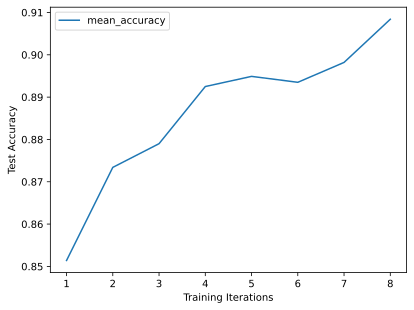

In [ ]:
%config InlineBackend.figure_format = 'svg'

best_result = results_grid.get_best_result(metric="mean_accuracy", mode="max")

print('Best result path:', best_result.path)
print("Best final iteration hyperparameter config:\n", best_result.config)

df = best_result.metrics_dataframe
df = df.drop_duplicates(subset="training_iteration", keep="last")
df.plot("training_iteration", "mean_accuracy")
plt.xlabel("Training Iterations")
plt.ylabel("Test Accuracy")
plt.show()